# Titanic Dataset

## Setup

### Include all libraries

In [282]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
%matplotlib inline

np.__version__, pd.__version__, sklearn.__version__, sns.__version__

('1.23.4', '1.5.0', '1.1.3', '0.12.0')

In [283]:
%load_ext version_information
%version_information

The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information


Software versions
Python 3.10.8 64bit [GCC 10.2.1 20210110]
IPython 8.6.0
OS Linux 5.10.104 linuxkit aarch64 with glibc2.31
Thu Nov 24 14:37:14 2022 UTC

### Download dataset

Please manually download the dataset `train.csv` from [here](https://www.kaggle.com/competitions/titanic/data) into the folder `data`.

In [284]:
raw_train_csv_path = 'data/train.csv'

while not os.path.isfile(raw_train_csv_path):
    print('Please sign in to Kaggle and download the dataset `train.csv` into the folder `data`.')
    input('Press Enter to continue...')

In [285]:
raw_df = pd.read_csv('data/train.csv')

## Data preparation

Ausgabe der ersten 5 Datensätze und des shapes des Datensatzes:

In [286]:
raw_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [287]:
raw_df.shape

(891, 12)

Ausgabe aller Spaltennamen und datentypen:

In [288]:
raw_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [289]:
raw_df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [290]:
for column in raw_df:
    if (raw_df[column].isnull().sum()):
        print(f'{column}: {raw_df[column].isnull().sum()} null values')

Age: 177 null values
Cabin: 687 null values
Embarked: 2 null values


Aufbereitung des Datensatzes:

In [299]:
def prepare_raw_df(df):
    # Entferne nicht benötigte Spalten 
    df = df.drop(['Name', 'Ticket'], axis=1)
    # Entferne Spalten mit fehlenden Werten
    df = df.drop(['Cabin'], axis=1)
    # Entferne die beiden Datensätze mit fehlenden `Embarked` Werten
    df = df.dropna(axis=0, subset=['Embarked'])
    # Berechne fehlende `Age` Werte
    df['Age'] = df.groupby(['Pclass','Sex'])['Age'].transform(lambda x: x.fillna(x.median()))
    # Ersetze kategorische Werte mit dummy werten
    df['Sex'] = df['Sex'].replace({'male': 0, 'female': 1})
    df['Embarked'] = df['Embarked'].replace({'S': 0, 'C': 1, 'Q': 2})
    # Spalten neu ordnen
    df = df[['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Survived']]
    # Spalten umbenennen
    df = df.rename(columns={ 'PassengerId': 'ID', 'Pclass': 'TicketClass', 'SibSp': 'NumOfSiblingsAndSpouses', 'Parch': 'NumOfParentsAndChildren', 'Embarked': 'PortOfEmbarkation' })
    return df

df = prepare_raw_df(raw_df)
df.head()

,ID,TicketClass,Sex,Age,NumOfSiblingsAndSpouses,NumOfParentsAndChildren,Fare,PortOfEmbarkation,Survived
0,1,3,0,22.0,1,0,7.2500,0,0
1,2,1,1,38.0,1,0,71.2833,1,1
2,3,3,1,26.0,0,0,7.9250,0,1
3,4,1,1,35.0,1,0,53.1000,0,1
4,5,3,0,35.0,0,0,8.0500,0,0


## Training

Erstellen der X und y Werte und splitten des Datensatzes in Trainings- und Testdaten:

In [305]:
from sklearn.model_selection import train_test_split

X = df.drop(['ID', 'Survived'], axis=1)
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

Accuracy = 0.8052434456928839
Precision = 0.7378640776699029
Recall = 0.7524752475247525
F1-Score = 0.7450980392156863


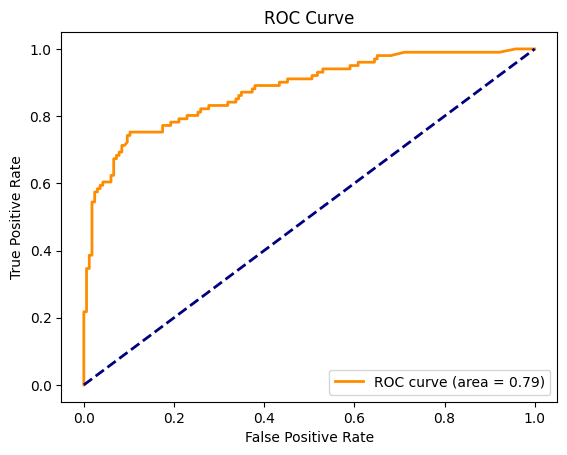

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


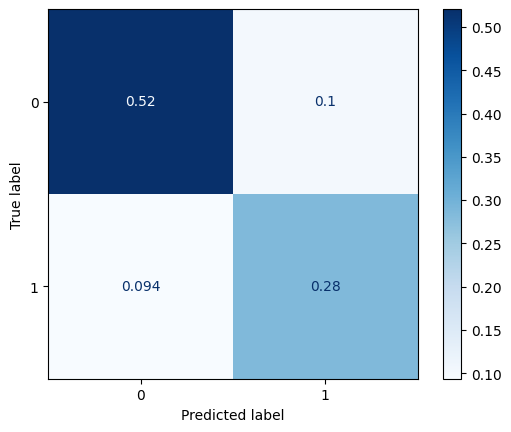

In [306]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, plot_confusion_matrix

def plot_roc_curve(false_positive_rate, true_positive_rate, roc_auc):
    lw = 2
    plt.plot(false_positive_rate, true_positive_rate, color='darkorange', lw=lw, label="ROC curve (area = %0.2f)" % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

def validate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print('Accuracy = {}'.format(accuracy))

    precision = precision_score(y_test, y_pred)
    print('Precision = {}'.format(precision))

    recall = recall_score(y_test, y_pred)
    print('Recall = {}'.format(recall))

    f1Score = f1_score(y_test, y_pred)
    print('F1-Score = {}'.format(f1Score))

    roc_auc = roc_auc_score(y_test, y_pred) 
    y_prob = model.predict_proba(X_test)  
    y_prob = y_prob[:, 1]  
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob) 
    plot_roc_curve(false_positive_rate, true_positive_rate, roc_auc)

    plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues, normalize = 'all')

from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(X_train, y_train)
validate_model(model, X_test, y_test)

## Monitoring

### WhyLabs

In [294]:
import getpass

# Set your org-id here - should be something like "org-xxxx"
print("Enter your WhyLabs Org ID...") 
os.environ["WHYLABS_DEFAULT_ORG_ID"] = input()

# Set your datased_id (or model_id) here - should be something like "model-xxxx"
print("Enter your WhyLabs Dataset ID...")
os.environ["WHYLABS_DEFAULT_DATASET_ID"] = input()

# Set your API key here
print("Enter your WhyLabs API key...")
os.environ["WHYLABS_API_KEY"] = getpass.getpass()

Enter your WhyLabs Org ID...
Enter your WhyLabs Dataset ID...
Enter your WhyLabs API key...


Split data into daily batches and upload:

In [295]:
from datetime import datetime, timezone, timedelta
import whylogs as why
from whylogs.api.writer.whylabs import WhyLabsWriter

writer = WhyLabsWriter()

df_splits = np.array_split(df, 7)

def log_data(df, timestamp):
    profile = why.log(df).profile()
    profile.set_dataset_timestamp(timestamp)
    writer.write(profile=profile.view())
    print('Logged profile for {}'.format(timestamp))

def add_random_column_outliers(df, column, num_of_outliers):
    df = df.copy(deep=True)
    df = df.reset_index()
    number_of_rows = df.shape[0]
    for i in range(num_of_outliers):
        random_row = np.random.randint(0, number_of_rows)
        df.loc[random_row, column] += round(np.random.uniform(low=150.0, high=200.0), 2)
    return df

for day, df_split in enumerate(df_splits):
    # Rename column `Survived` to `output_survived`
    df_split.rename(columns={ 'Survived': 'output_survived' }, inplace=True)
    if day == 3:
        df_split = add_random_column_outliers(df_split, 'Age', 10)
    timestamp = datetime.now(timezone.utc) - timedelta(days=day + 1)
    log_data(df_split, timestamp)

/tmp/ipykernel_56499/1328792212.py:12: DeprecationWarning: `profile` is deprecated as an argument to `write`; use `file` instead.
  writer.write(profile=profile.view())


ValueError: API key too short

### Superwise

In [296]:
import getpass

import os
from superwise import Superwise

print("Enter your Superwise Client ID...")
os.environ['SUPERWISE_CLIENT_ID'] = input()

print("Enter your Superwise Secret...")
os.environ['SUPERWISE_SECRET'] = getpass.getpass()

sw = Superwise()

In [312]:
from datetime import datetime
from superwise.models.dataset import Dataset
from superwise.models.version import Version

def prepare_sw_data(df):
    df = df.copy(deep=True)
    df['timestamp'] = datetime.today().strftime('%Y-%m-%d %H:%M:%S.%f')
    return df

print("Enter your Superwise Project ID...")
sw_project_id = 4 #input()

print("Enter your Superwise Project ID...")
sw_model_id = 13 #input()

sw_train_csv_path = 'data/sw_train.csv'

sw_df = prepare_sw_data(df)
sw_df.to_csv(sw_train_csv_path, index=False)

# Create a new dataset
sw_dataset = Dataset(name=f"Training Dataset", files=[sw_train_csv_path], project_id=sw_project_id)
sw_dataset = sw.dataset.create(sw_dataset)

# Create a new version
version = Version(name=datetime.today().strftime('%Y-%m-%d-%H-%M-%S'), model_id=sw_model_id, dataset_id=sw_dataset.id)
new_version = sw.version.create(version)

# Upload the new version
new_version = sw.version.activate(new_version.id)

Enter your Superwise Project ID...
Enter your Superwise Project ID...


### Interaktive Demo

In [ ]:
def predictSingleValue(model, ticket_class, sex, age, num_of_siblings_and_spouses, num_of_parents_and_children, fare, port_of_embarkation):
    input_dict = {
        'TicketClass': [ticket_class],
        'Sex': [sex],
        'Age': [age],
        'NumOfSiblingsAndSpouses': [num_of_siblings_and_spouses],
        'NumOfParentsAndChildren': [num_of_parents_and_children],
        'Fare': [fare],
        'PortOfEmbarkation': [port_of_embarkation],
    }
    input_df = pd.DataFrame(data=input_dict)
    return model.predict(input_df)[0]

predictSingleValue(model, 2, 1, 34.5, 0, 0, 8, 2)

1

## Auswertung

Darstellung der Korrelationen zwischen `Survived` und den restlichen Columns:

<AxesSubplot: >

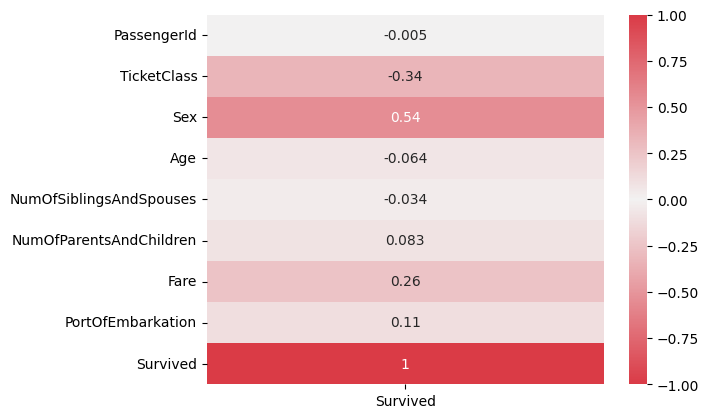

In [ ]:
corr = df.corrwith(df['Survived'])
corr_df = pd.DataFrame({ 'Survived': corr }, index=df.columns)
cmap = sns.diverging_palette(10,10, as_cmap=True)
sns.heatmap(corr_df, annot=True, cmap=cmap, vmin=-1, vmax=1)